# Binomial Option Pricing Model

This notebook explains the binomial option pricing model for European call options and provides a Python implementation with visualizations.

## 1. Mathematical Foundation

The binomial model assumes that the price of an underlying asset follows a discrete-time process where in each period, the price can either go up by a factor $u$ or down by a factor $d$.

### Key variables

$u = $ Change in the 'up' state <br>
$d = $ Change in the 'down' state (commonly assumed to be $d=1/u$) <br>
$p_u = $ Probability of the up state <br>
$p_d = 1- p_u =$ Probability of the down state <br>

### Modelling prices and payoffs

Using these variables, a tree of prices (and payoffs) are created to value the instrument in question. 

There are different methods to specify a binomial model.   The Cox Ross Rubinstein method assumes:

$u = e^{\sigma \sqrt{\Delta t}}$<br>
$d = 1/u = e^{-\sigma \sqrt{\Delta t}}$<br>
$p_u = \frac{e^{r\Delta t}-d}{u-d}$ <br>
$p_d = 1-p_u$<br>
<br>
Where:

$r=$ Risk free rate <br>
$t=$ Time to maturity <br>
$\Delta t =$ Change in time for each step <br>
$\sigma=$ Asset volatility <br>

## 2. Asset path visualisation

We can use the `matplotlib` library in Python to visualise what the binomial tree looks like.<br><br>
Notice that we get a distribution skewed toward higher values. This will be a familiar outcome if you have studied dertivatives.<br><br>
Notice that thicker lines are denoting the paths "more travelled".

In [9]:
# First import the required libraries

import numpy as np
import matplotlib.pyplot as plt

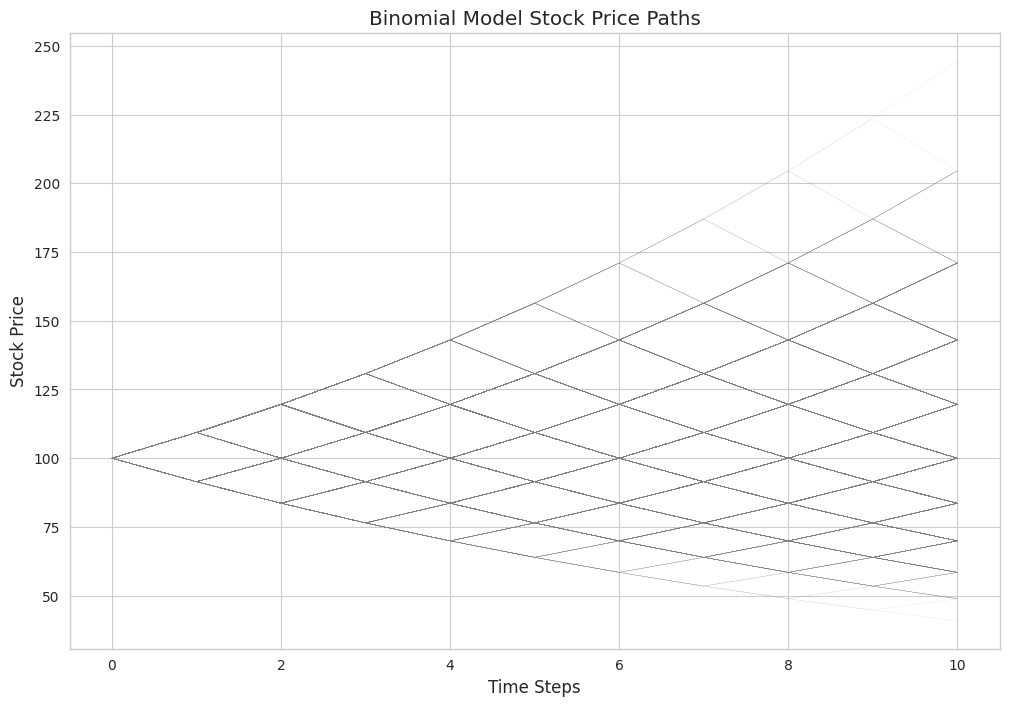

In [10]:
# Create paths for the binomial model and show them on a chart

# Constants
YEARS = 2
TIME_STEP_FRACTION = 1 / 5  # number of time steps per year
SIGMA = 0.2  # volatility of the asset
STARTING_PRICE = 100
RISK_FREE_RATE = 0.025

time_steps = int(YEARS / TIME_STEP_FRACTION)
up_move = np.exp(SIGMA*np.sqrt(TIME_STEP_FRACTION))
down_move = 1/up_move
probability_up = (np.exp(RISK_FREE_RATE*TIME_STEP_FRACTION)-down_move)/(up_move-down_move)
disc = np.exp(RISK_FREE_RATE*YEARS)

paths_so_far = np.array([[STARTING_PRICE]])

def add_timestep(paths_so_far):
    new_paths = []
    for path in paths_so_far:
        new_paths.append(np.append(path, path[-1] * up_move))
        new_paths.append(np.append(path, path[-1] * down_move))
    return np.array(new_paths)

new_paths = add_timestep(paths_so_far)

for i in range(time_steps - 1):
    new_paths = add_timestep(new_paths)

# create a line chart of the new_paths
for path in new_paths:
    plt.plot(path, color='grey', linewidth=0.05)

plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Binomial Model Stock Price Paths')
plt.show()

## 2. Using the Binomial Model to Value a European Call Option

A call option is the right (but not the obligation) to buy an asset (let's assume a stock) on a known date in the future at a specified strike price.

We can value this using the binomial model by:

1. Mapping the stock price tree through time.

2. Calculating the option payout at maturity using the formula:

   $$
   \text{Payout} = \max(S_T - K, 0)
   $$

   where:<br>
   $S_T \text{: Stock price at maturity.}$<br>
   $K \text{: Strike price.}$<br>

3. Working backward through the tree to calculate the option value at each node using the risk-neutral valuation formula:

   $$
   C = e^{-r \Delta t} \left( p \cdot C_u + (1 - p) \cdot C_d \right)
   $$

   where:
   - $C = $ Option value at the current node.
   - $C_u = $ Option value at the "up" node.
   - $C_d = $ Option value at the "down" node.
   - $p = $ Risk-neutral probability.
   - $r = $ Risk-free interest rate.
   - $\Delta t = $ Time step.

This process allows us to determine the fair value of the call option at the initial time step (time zero).

In [ ]:
def binomial_european_call(S0, K, T, r, sigma, N):
    """Calculate European call option price using binomial model"""
    # Calculate time step
    dt = T/N
    
    # Calculate up and down factors
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    
    # Calculate risk-neutral probability
    p = (np.exp(r * dt) - d) / (u - d)
    
    # Initialize stock price tree
    stock_tree = np.zeros((N+1, N+1))
    
    # Populate the stock price tree through time
    for i in range(N+1):
        for j in range(i+1):
            stock_tree[i, j] = S0 * (u ** j) * (d ** (i - j))
    
    # Initialize option value tree
    option_tree = np.zeros((N+1, N+1))
    
    # Calculate call option payoffs at expiration
    for j in range(N+1):
        option_tree[N, j] = max(0, stock_tree[N, j] - K)
    
    # Work backwards discounting and reflecting risk-neutral probabilities to calculate option value at each node
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            option_tree[i, j] = np.exp(-r * dt) * (p * option_tree[i+1, j+1] + (1-p) * option_tree[i+1, j])
    
    return option_tree[0, 0], stock_tree, option_tree

## Alternative visualisation to simulateously show stock values and option values

Here we use the `networkx` library to visualise the stock price binomial tree and the option price binomial tree.   `networkx` is designed for presenting networks and visualising network style information making in well suited for a tree.  We are using `networkx` in conjunction with `matplotlib` in such a way that `networkx` provides tools to create and manipulate graphs, while `matplotlib` is used to render the visualizations.  We also use `seaborn` to add particular visual styles.

We could have used `matplotlib` on its own as above with two subplots, but I wanted to show an alternative visualisation tool.

In [ ]:

import networkx as nx
import seaborn as sns

# Set plotting style
plt.style.use('ggplot')
sns.set_style("whitegrid") # the seaborn library is being used to set the style of the plots
plt.rcParams['figure.figsize'] = (12, 8)

In [15]:
def plot_binomial_tree(stock_tree, option_tree, N):
    """Visualize binomial tree with stock prices and option values"""
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes and edges
    for i in range(N+1):
        for j in range(i+1):
            node_id = f"{i},{j}"
            stock_price = stock_tree[i, j]
            option_value = option_tree[i, j]
            
            G.add_node(node_id, pos=(i, j), stock_price=stock_price, option_value=option_value)
            
            if i < N:
                G.add_edge(node_id, f"{i+1},{j}")
                G.add_edge(node_id, f"{i+1},{j+1}")
    
    # Get positions for nodes
    pos = {}
    for node in G.nodes():
        i, j = map(int, node.split(','))
        pos[node] = (i, j - i/2)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set titles
    fig.suptitle(f"European Call Option - Binomial Tree (N={N})")
    ax1.set_title("Stock Price Tree")
    ax2.set_title("Option Value Tree")
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.3)
    nx.draw_networkx_edges(G, pos, ax=ax2, alpha=0.3)
    
    # Draw nodes with color based on values
    node_colors1 = [stock_tree[int(node.split(',')[0]), int(node.split(',')[1])] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=700, node_color=node_colors1, cmap=plt.cm.Greens)
    
    node_colors2 = [option_tree[int(node.split(',')[0]), int(node.split(',')[1])] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, ax=ax2, node_size=700, node_color=node_colors2, cmap=plt.cm.Oranges)
    
    # Add colorbars
    sm1 = plt.cm.ScalarMappable(cmap=plt.cm.Greens, norm=plt.Normalize(vmin=min(node_colors1), vmax=max(node_colors1)))
    sm1.set_array([])
    plt.colorbar(sm1, ax=ax1).set_label('Stock Price')
    
    sm2 = plt.cm.ScalarMappable(cmap=plt.cm.Oranges, norm=plt.Normalize(vmin=min(node_colors2), vmax=max(node_colors2)))
    sm2.set_array([])
    plt.colorbar(sm2, ax=ax2).set_label('Option Value')
    
    # Add labels
    labels1 = {node: f"${G.nodes[node]['stock_price']:.2f}" for node in G.nodes()}
    labels2 = {node: f"${G.nodes[node]['option_value']:.2f}" for node in G.nodes()}
    
    nx.draw_networkx_labels(G, pos, labels=labels1, ax=ax1, font_size=8)
    nx.draw_networkx_labels(G, pos, labels=labels2, ax=ax2, font_size=8)
    
    # Remove axes
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    plt.tight_layout()
    plt.show()

### Bringing it all together to price and show a European Call Option

European Call Option Price: $9.9705


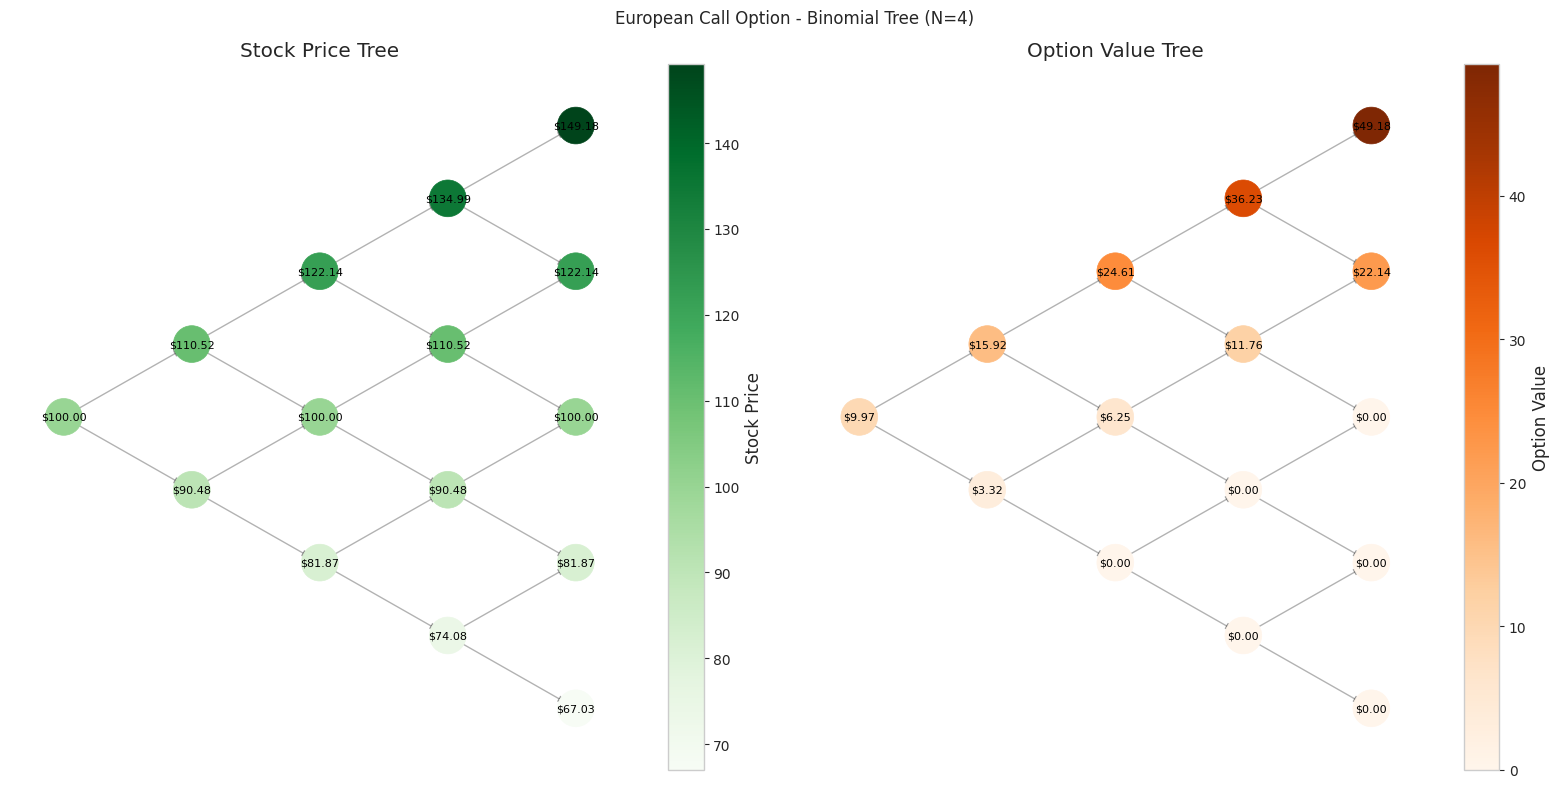

In [16]:
# Define parameters
S0 = 100    # Initial stock price
K = 100     # Strike price
T = 1       # Time to expiration (in years)
r = 0.05    # Risk-free interest rate
sigma = 0.2 # Volatility
N = 4       # Number of time steps

# Price the European call option
call_price, stock_tree, option_tree = binomial_european_call(S0, K, T, r, sigma, N)
print(f"European Call Option Price: ${call_price:.4f}")

# Visualize the binomial tree
plot_binomial_tree(stock_tree, option_tree, N)

### Parameter Impact Analysis

Let's examine how different parameters affect the option price.

In [5]:
def analyze_parameter_effect(param_name, param_range, S0, K, T, r, sigma, N):
    """Analyze how changing a parameter affects option price"""
    prices = []
    
    for value in param_range:
        params = {'S0': S0, 'K': K, 'T': T, 'r': r, 'sigma': sigma, 'N': N}
        params[param_name] = value
        
        if param_name == 'N':
            params['N'] = int(value)
            
        price, _, _ = binomial_european_call(params['S0'], params['K'], params['T'], 
                                           params['r'], params['sigma'], params['N'])
        prices.append(price)
    
    plt.figure(figsize=(8, 6))
    plt.plot(param_range, prices, 'o-', linewidth=2)
    
    param_labels = {
        'S0': 'Initial Stock Price ($)',
        'K': 'Strike Price ($)',
        'T': 'Time to Expiration (years)',
        'r': 'Risk-Free Rate',
        'sigma': 'Volatility',
        'N': 'Number of Time Steps'
    }
    
    plt.xlabel(param_labels.get(param_name, param_name))
    plt.ylabel('Option Price ($)')
    plt.title(f'Effect of {param_labels.get(param_name, param_name)} on Call Option Price')
    plt.grid(True)
    
    if param_name in ['r', 'sigma']:
        plt.gca().set_xticklabels([f'{x*100:.0f}%' for x in param_range])
    
    plt.tight_layout()
    plt.show()

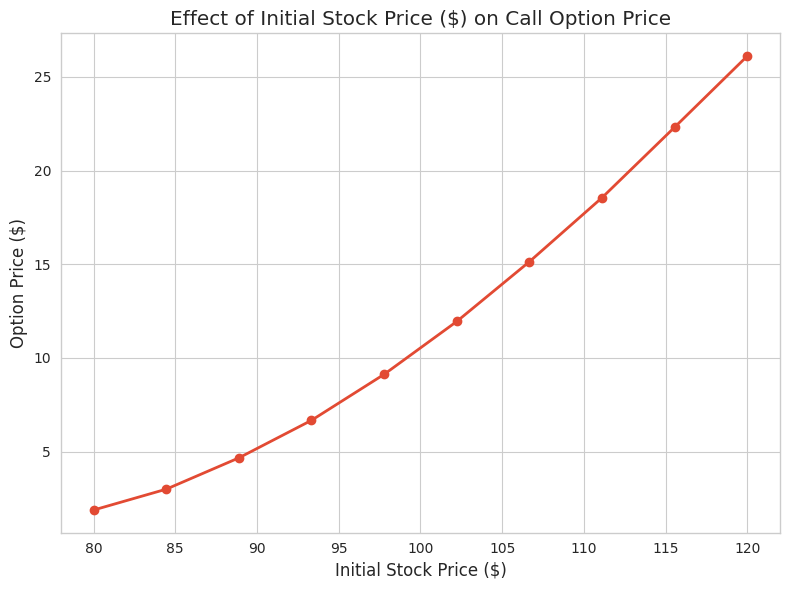

In [6]:
# Vary stock price
analyze_parameter_effect('S0', np.linspace(80, 120, 10), S0, K, T, r, sigma, 20)

/tmp/ipykernel_17331/2622609996.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{x*100:.0f}%' for x in param_range])


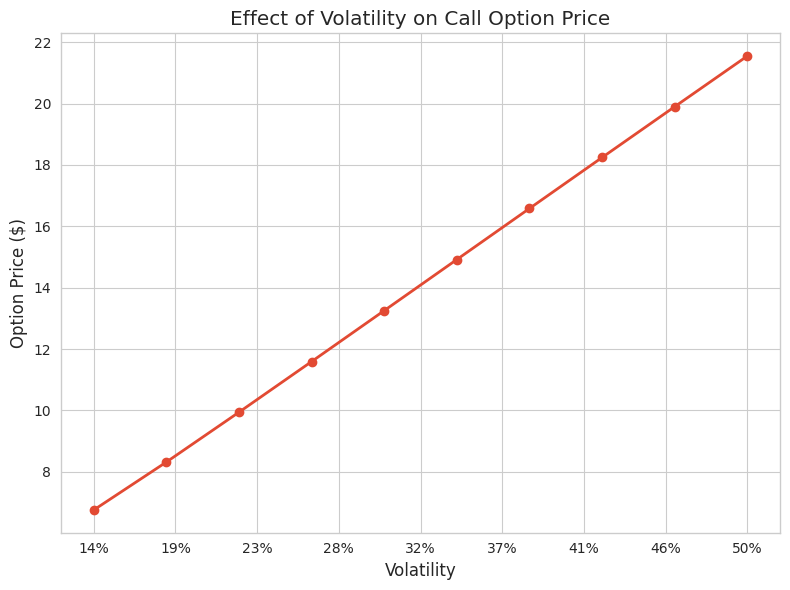

In [7]:
# Vary volatility
analyze_parameter_effect('sigma', np.linspace(0.1, 0.5, 10), S0, K, T, r, sigma, 20)

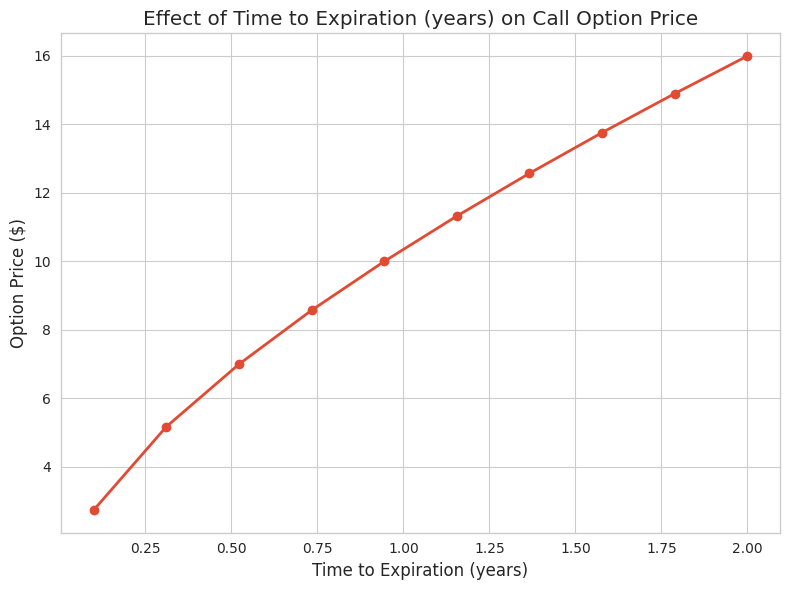

In [8]:
# Vary time to expiration
analyze_parameter_effect('T', np.linspace(0.1, 2, 10), S0, K, T, r, sigma, 20)

### Conclusion

The binomial option pricing model provides a powerful and intuitive framework for valuing options. By constructing a tree of possible future stock prices and working backward to calculate option values, we can accurately price European call options.

Key insights from this implementation:

1. As the number of time steps increases, the model becomes more accurate
2. Higher volatility increases call option values due to greater upside potential
3. Longer time to expiration typically increases option values
4. The model can be extended to price various option types and incorporate dividends

This discrete-time approach also forms the foundation for understanding more complex option pricing models.